In [ ]:
#umap,etc on corrected graph
#graph intrinsic dimension before/after hubness

In [4]:
%%R
# The following initializes usage of Bioc devel
# BiocManager::install(version='devel')

BiocManager::install("DuoClustering2018")

R[write to console]: Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

R[write to console]: Installing package(s) 'DuoClustering2018'

R[write to console]: also installing the dependencies ‘interactiveDisplayBase’, ‘AnnotationHub’, ‘BiocFileCache’, ‘ExperimentHub’


R[write to console]: trying URL 'https://bioconductor.org/packages/3.10/bioc/src/contrib/interactiveDisplayBase_1.24.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 13890 bytes (13 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]

In [2]:
%%html

<style>
    .jp-OutputArea-child {
        display: inline-block;
    }
</style>
<!https://stackoverflow.com/questions/21754976/ipython-notebook-arrange-plots-horizontally>

In [1]:
import sys
import os
import sklearn.metrics
import sklearn.cluster
import skhubness
from os import path
current_folder = path.dirname(path.abspath('')) 
sys.path.append(current_folder)
from geomle import geomle, mle, DataGenerator
import re
import seaborn as sns
import scanpy as sc
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
import multiprocessing as mp
import multiprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
from matplotlib import pyplot as plt
import umap
import skdim
import seaborn as sns
import random
import time
import numpy as np
import pandas as pd
import pickle
import rpy2
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages
from functools import wraps
import subprocess
from operator import itemgetter
from utils import *
import anndata2ri
import gc

anndata2ri.activate()
readRDS = ro.r['readRDS']
ro.numpy2ri.activate()
utils = rpackages.importr('utils')
%load_ext rpy2.ipython
%R .libPaths(c('/home/utilisateur/anaconda3/lib/R/library',.libPaths()))

/home/utilisateur/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/utilisateur/.local/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


array(['/home/utilisateur/anaconda3/lib/R/library',
       '/home/utilisateur/R/x86_64-pc-linux-gnu-library/3.6',
       '/usr/local/lib/R/site-library', '/usr/lib/R/site-library',
       '/usr/lib/R/library'], dtype='<U51')

In [1]:
import louvain
import leidenalg
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from IPython.display import display

def color_sign_df(value):
    """
    Colors elements in a dateframe
    green if positive and red if
    negative. Does not color NaN
    values.
    """

    if value < 0:
        color = 'red'
    elif value > 0:
        color = 'green'
    else:
        color = 'black'

    return 'color: %s' % color

def get_split(X,y,stratified=True,n_splits=5,leave_out=.1,random_state=0):
    if stratified:
        split = StratifiedShuffleSplit(n_splits=n_splits, test_size=leave_out, random_state=random_state).split(X,y)
    else:
        split = ShuffleSplit(n_splits=n_splits, test_size=leave_out, random_state=random_state).split(X)        
    
    subs_data = []
    for sel_idx,excl_idx in split:
        subs_data.append((X[sel_idx],y[sel_idx]))
    return subs_data, split

def get_rand_score(y,res_dict,keys_list=['leiden','louvain','spectral','spectral_hub']):
        return pd.Series(data=[sklearn.metrics.cluster.adjusted_rand_score(y,res_dict[k]) for k in keys_list],index=keys_list)

def test_kneighbors_clustering(X,y,cv=5,n_neighbors=10,metric='cosine',hubness='dis_sim_local',hubness_params=None):

    knn_standard = skhubness.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors,
                                        metric=metric)
    acc_standard = cross_val_score(knn_standard, X, y, cv=cv)

    # kNN with hubness reduction
    knn_hubness = skhubness.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors,
                                  metric=metric,
                                  hubness=hubness,
                                  hubness_params=hubness_params)
    acc_hubness = cross_val_score(knn_hubness, X, y, cv=cv)

    print(f'Accuracy (vanilla kNN): {acc_standard.mean():.3f}')
    print(f'Accuracy (kNN with hubness reduction): {acc_hubness.mean():.3f}')

    hub = skhubness.Hubness(k=n_neighbors, metric=metric)
    hub.fit(X)
    k_skew = hub.score()
    print(f'\nSkewness = {k_skew:.3f}')
    print(f'Robin hood index: {hub.robinhood_index:.3f}')
    print(f'Antihub occurrence: {hub.antihub_occurrence:.3f}')
    print(f'Hub occurrence: {hub.hub_occurrence:.3f}')


    hub_red = skhubness.Hubness(k=n_neighbors, metric=metric,
                     hubness=hubness)
    hub_red.fit(X)
    k_skew_hubness = hub_red.score()
    print(f'\nSkewness after Hubness reduction: {k_skew_hubness:.3f} '
          f'(reduction of {k_skew - k_skew_hubness:.3f})')
    print(f'Robin hood: {hub_red.robinhood_index:.3f} '
          f'(reduction of {hub.robinhood_index - hub_red.robinhood_index:.3f})')
    print(f'Antihub occurrence: {hub_red.antihub_occurrence:.3f}')
    print(f'Hub occurrence: {hub_red.hub_occurrence:.3f}')
    
    return acc_standard, acc_hubness, k_skew, k_skew_hubness



def vanilla_clustering(X, adata, metric='cosine', n_neighbors = 10, n_clusters = None, resolution = 1.0, weighted = True, seed = 0, store = True):
    #base performance - vanilla kNN
    knn = skhubness.neighbors.NearestNeighbors(n_neighbors=n_neighbors,metric=metric)
    knn.fit(X)
    adjmat = knn.kneighbors_graph(mode='connectivity')
    weighted_adjmat = knn.kneighbors_graph(mode='distance')


    #spectral clustering input
    if n_clusters is None:
        n_clusters=len(adata.obs['phenoid'].unique())  
    affinity_matrix = 0.5 * (adjmat + adjmat.T)
    weighted_affinity_matrix = 0.5 * (weighted_adjmat + weighted_adjmat.T)
    #spectral clustering
    spectral = sklearn.cluster.SpectralClustering(n_clusters = n_clusters,
                                       affinity = 'precomputed',
                                       random_state = seed)
    spectral_clus = spectral.fit(affinity_matrix).labels_


    #louvain/leiden input
    louvain.set_rng_seed(seed)
    if weighted:
        G = sc.utils.get_igraph_from_adjacency(weighted_adjmat, directed=False)
        weights = np.array(G.es["weight"]).astype(np.float64)
    else:
        G = sc.utils.get_igraph_from_adjacency(adjmat, directed=False)
        weights = None
    #louvain/leiden clustering
    part_louvain = louvain.find_partition(graph = G, 
                                       partition_type = louvain.RBConfigurationVertexPartition, 
                                       weights = weights,
                                       resolution_parameter=1.0)
    louvain_clus = np.array(part_louvain.membership)

    part_leiden = leidenalg.find_partition(graph = G, 
                             partition_type = leidenalg.RBConfigurationVertexPartition, 
                             weights = weights,
                             resolution_parameter=1.0,
                             seed=seed)
    leiden_clus = np.array(part_leiden.membership)
    
    if store:
        adata.obs['louvain_base'] = louvain_clus
        adata.obs['leiden_base'] = leiden_clus
        adata.obs['spectral'] = spectral_clus
        
    del locals()['adata'], locals()['X']
    return locals()

def hubness_aware_clustering(X, adata, metric='cosine', hubness='local_scaling', hubness_params=None, n_neighbors = 10, n_clusters = None, resolution = 1.0 , weighted = True, seed = 0, store = True):
    
    # performance with hubness reduced 
    knn_hub = skhubness.neighbors.NearestNeighbors(n_neighbors=n_neighbors,metric=metric,hubness=hubness,hubness_params=hubness_params)
    knn_hub.fit(X)
    adjmat = knn_hub.kneighbors_graph(mode='connectivity')
    weighted_adjmat = knn_hub.kneighbors_graph(mode='distance')

    #spectral clustering input
    if n_clusters is None:
        n_clusters=len(adata.obs['phenoid'].unique())
    affinity_matrix = 0.5 * (adjmat + adjmat.T)
    weighted_affinity_matrix = 0.5 * (weighted_adjmat + weighted_adjmat.T)
    #spectral clustering
    spectral = sklearn.cluster.SpectralClustering(n_clusters = n_clusters,
                                       affinity = 'precomputed',
                                       random_state = seed)
    spectral_clus = spectral.fit(affinity_matrix).labels_


    #louvain/leiden input
    louvain.set_rng_seed(seed)
    if weighted:
        G = sc.utils.get_igraph_from_adjacency(weighted_adjmat, directed=False)
        weights = np.array(G.es["weight"]).astype(np.float64)
    else:
        G = sc.utils.get_igraph_from_adjacency(adjmat, directed=False)
        weights = None
    #louvain/leiden clustering
    part_louvain = louvain.find_partition(graph = G, 
                                       partition_type = louvain.RBConfigurationVertexPartition, 
                                       weights = weights,
                                       resolution_parameter=resolution)
    louvain_clus = np.array(part_louvain.membership)

    part_leiden = leidenalg.find_partition(graph = G, 
                             partition_type = leidenalg.RBConfigurationVertexPartition, 
                             weights = weights,
                             resolution_parameter=resolution,
                             seed=seed)
    leiden_clus = np.array(part_leiden.membership)
    
    if store:
        adata.obs['louvain_hub'] = louvain_clus
        adata.obs['leiden_hub'] = leiden_clus
        adata.obs['spectral_hub'] = spectral_clus
    
    del locals()['adata'], locals()['X']
    return locals()


def clustering_analysis(adata, 
                        n_neighbors = 10,
                        n_clusters = None,
                        metric = 'cosine',
                        resolution = 1.0,
                        weighted = True,  #weighted adjmat for louvain/leiden clustering ?
                        seed = 0,
                        n_splits = 10,    #repeat subsampling x times
                        leave_out = 0.05, #subsampling fraction
                        hubness = 'local_scaling',
                        hubness_params = {'method':'nicdm'},
                        show_plot = True,
                        show_score = True,
                        plot_title = None):
    
    if n_clusters is None:
        n_clusters = len(adata.obs['phenoid'].unique())

    #preprocessing
    if np.all(np.around(adata.X)==adata.X): #is count matrix?
        sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, metric=metric)
    sc.tl.leiden(adata,resolution=resolution)
    sc.tl.louvain(adata,resolution=resolution)

    #cluster all data, store results in adata
    clus_results = vanilla_clustering(adata.X, adata, 
                                      metric=metric, n_neighbors=n_neighbors,n_clusters = n_clusters, 
                                      resolution = resolution, weighted = weighted, seed = seed,store=True)
    hubclus_results = hubness_aware_clustering(adata.X, adata, 
                                               metric=metric, hubness=hubness, hubness_params=hubness_params, 
                                               n_neighbors=n_neighbors,n_clusters = n_clusters, 
                                               resolution = resolution, weighted = weighted, seed = seed,store=True)

    #full clustering results are stored in adata.obs directly with these keys
    keys = ['leiden_base','leiden_hub','louvain_base','louvain_hub','spectral','spectral_hub','leiden','louvain','phenoid']
    randscores = adata.uns['full_randscore'] = get_rand_score(adata.obs['phenoid'],adata.obs,keys)

    #scatter plot results
    if show_plot:
        f,ax=plt.subplots(3,3,figsize=(20,10))
        ax=list(ax.flat)
        for i,k in enumerate(keys):
            col, legend = labels_to_color(adata.obs[k])
            ax[i].set_title(k+f' {randscores[k]:.2f}')
            ax[i].scatter(*adata.obsm['X_tsne'].T,c=col,s=5)
            ax[i].legend(handles=legend,bbox_to_anchor=[0,0,1,1])
        if plot_title is not None:
            plt.suptitle(plot_title,y=1.05)
        plt.tight_layout()
        plt.show()


    #cluster all data stratified or non-stratified subsamples, store results in adata
    keys = ['leiden_clus','louvain_clus','spectral_clus'] #result keys

    for strat in [True,False]:

        subs_data, split = get_split(adata.X, y=adata.obs['phenoid'], stratified=strat, n_splits=n_splits, leave_out=leave_out)

        randscores = []
        randscores_hub = []
        for it,(data,labels) in enumerate(subs_data): 
            #run clustering
            clus_results = vanilla_clustering(data, adata, 
                                              metric=metric,n_neighbors=n_neighbors, n_clusters = n_clusters, 
                                              resolution = resolution, weighted = weighted, seed = seed, store = False)
            hubclus_results = hubness_aware_clustering(data, adata, 
                                              metric=metric, hubness=hubness, hubness_params=hubness_params,
                                              n_neighbors=n_neighbors, n_clusters = n_clusters, 
                                              resolution = resolution, weighted = weighted, seed = seed, store = False)

            #get scores
            randscores.append(get_rand_score(labels, clus_results,keys))
            randscores_hub.append(get_rand_score(labels, hubclus_results, keys))

        #final storage of scores
        if strat:
            adata.uns['stratsubs_randscores'] = pd.concat(randscores,axis=1)
            adata.uns['stratsubs_randscores_hub'] = pd.concat(randscores_hub,axis=1)
        else:
            adata.uns['subs_randscores'] = pd.concat(randscores,axis=1)
            adata.uns['subs_randscores_hub'] = pd.concat(randscores_hub,axis=1)
            
            
    #hubness before/after
    hub = skhubness.Hubness(k=n_neighbors, metric=metric,random_state=seed,return_value='all')
    hub.fit(adata.X)
    hub_scores = hub.score()
    hub_df = pd.DataFrame.from_dict(data=hub_scores,orient='index',columns=['Base hubness'])
    del hub
    gc.collect()
    
    hub_red = skhubness.Hubness(k=n_neighbors, metric=metric,random_state=seed,return_value='all',
                     hubness=hubness,hubness_params=hubness_params)
    hub_red.fit(adata.X)
    hub_red_scores = hub_red.score()
    hub_red_df = pd.DataFrame.from_dict(data=hub_red_scores,orient='index',columns=['Reduced hubness'])
    del hub_red
    gc.collect()
    adata.uns['Hubness_df'] = pd.concat((hub_df,hub_red_df),axis=1)


    if show_score:
        display((adata.uns['stratsubs_randscores_hub']-adata.uns['stratsubs_randscores']).style.applymap(color_sign_df))
        display(adata.uns['Hubness_df'])

# Run all datasets filtered

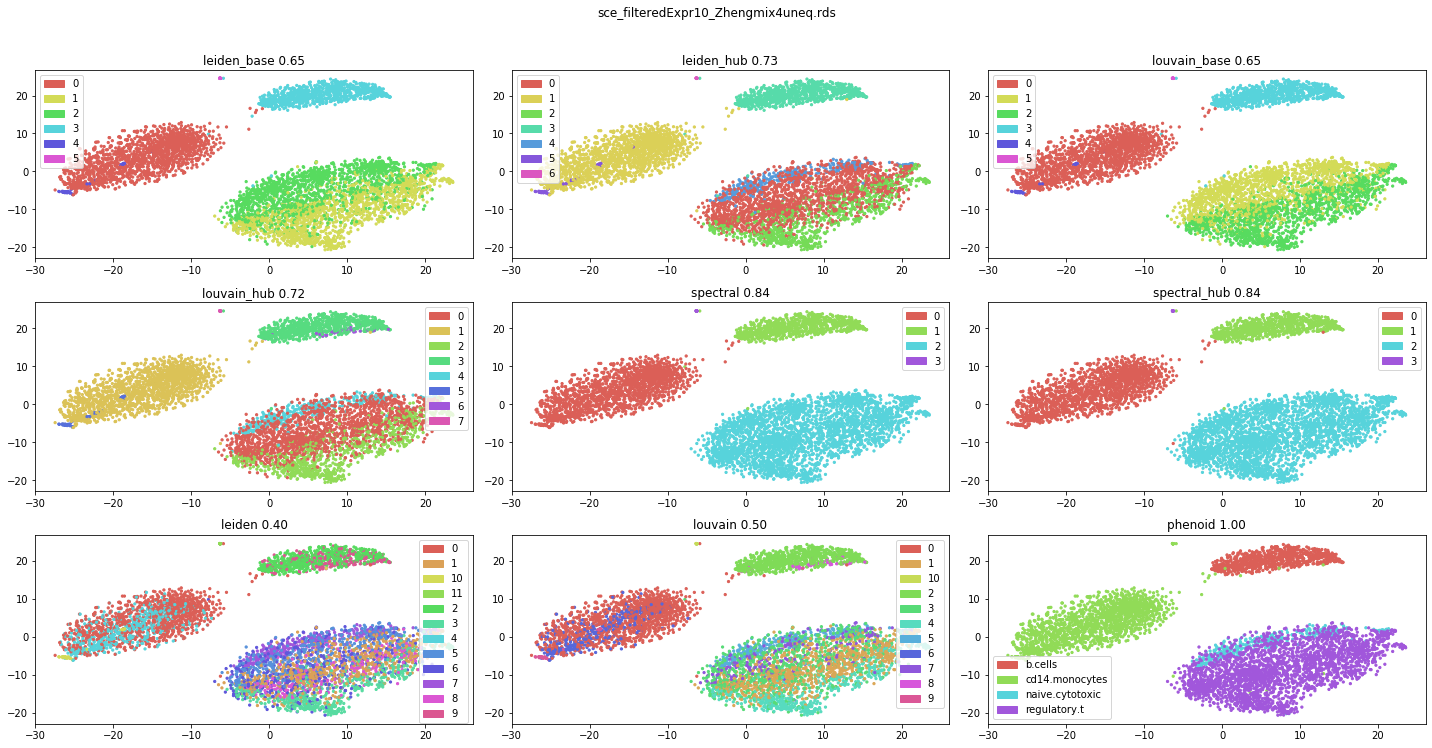

Base hubness  \
k_skewness                                                      8.74765   
k_skewness_truncnorm                                            1.32894   
atkinson                                                       0.779923   
gini                                                           0.897614   
robinhood                                                      0.762426   
antihubs              [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 18, ...   
antihub_occurrence                                             0.561896   
hubs                  [15, 34, 35, 40, 45, 50, 52, 55, 62, 64, 73, 9...   
hub_occurrence                                                 0.842984   
groupie_ratio                                                 0.0122233   

                                                        Reduced hubness  
k_skewness                                                      3.39052  
k_skewness_truncnorm                                              1.049  
atkinson                                                        0.42847  
gini                                                           0.660148  
robinhood                                                      0.502853  
antihubs              [5, 10, 11, 18, 19, 20, 26, 37, 42, 44, 48, 67...  
antihub_occurrence                                             0.230433  
hubs                  [15, 25, 34, 35, 36, 40, 45, 52, 54, 55, 62, 7...  
hub_occurrence                                                 0.597474  
groupie_ratio                                                0.00350795

... storing 'barcode' as categorical
... storing 'phenoid' as categorical




-------------------------------------------------------------------------------------------------------------





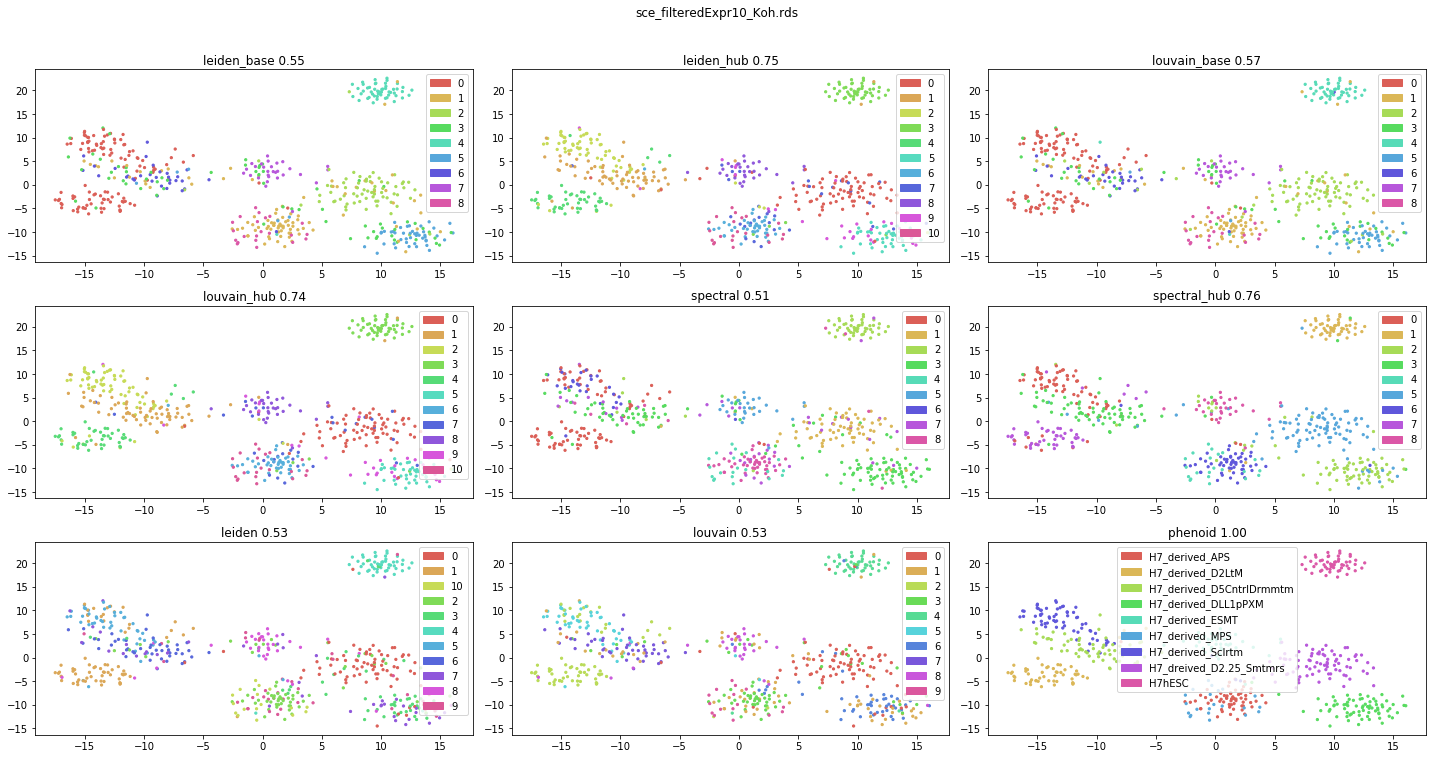

Base hubness  \
k_skewness                                                      1.07551   
k_skewness_truncnorm                                           0.837147   
atkinson                                                       0.278353   
gini                                                           0.515603   
robinhood                                                      0.386441   
antihubs              [7, 32, 44, 54, 77, 125, 141, 142, 145, 147, 1...   
antihub_occurrence                                             0.135593   
hubs                  [6, 11, 20, 23, 35, 41, 48, 53, 57, 58, 60, 63...   
hub_occurrence                                                 0.444444   
groupie_ratio                                                0.00885122   

                                                        Reduced hubness  
k_skewness                                                     0.358517  
k_skewness_truncnorm                                           0.333429  
atkinson                                                      0.0740107  
gini                                                           0.283236  
robinhood                                                      0.202072  
antihubs                                                [301, 367, 385]  
antihub_occurrence                                           0.00564972  
hubs                  [6, 35, 76, 176, 193, 241, 250, 280, 286, 292,...  
hub_occurrence                                                0.0779661  
groupie_ratio                                                 0.0047081

... storing 'LibraryName' as categorical
... storing 'phenoid' as categorical




-------------------------------------------------------------------------------------------------------------





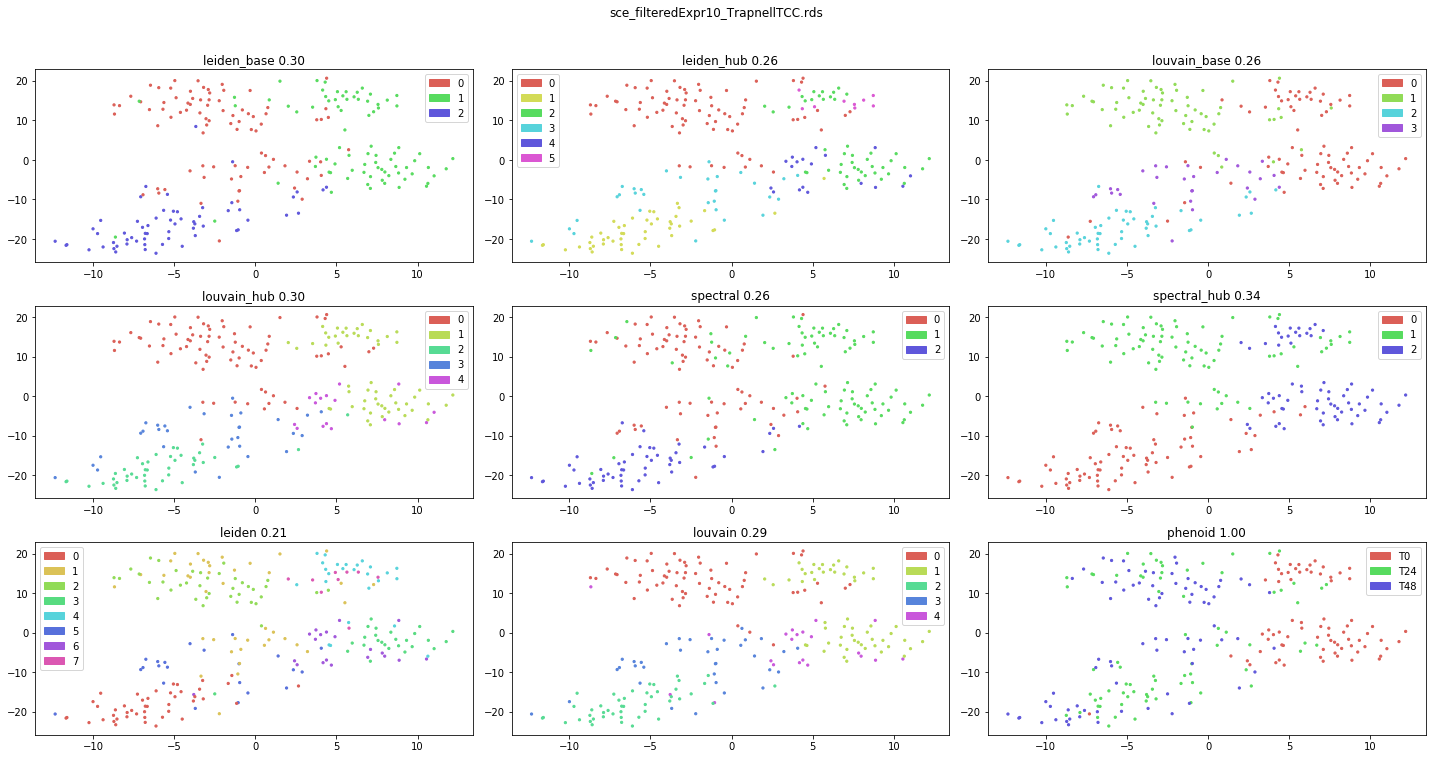

Base hubness  \
k_skewness                                                      3.50653   
k_skewness_truncnorm                                            1.21279   
atkinson                                                       0.743113   
gini                                                           0.858511   
robinhood                                                      0.743612   
antihubs              [4, 5, 8, 9, 10, 11, 17, 20, 22, 24, 25, 26, 2...   
antihub_occurrence                                             0.590308   
hubs                  [0, 1, 2, 3, 6, 7, 12, 19, 23, 27, 29, 32, 34,...   
hub_occurrence                                                 0.864317   
groupie_ratio                                                 0.0801762   

                                                        Reduced hubness  
k_skewness                                                      1.65446  
k_skewness_truncnorm                                            0.87163  
atkinson                                                       0.264789  
gini                                                           0.519886  
robinhood                                                      0.384581  
antihubs              [5, 9, 22, 24, 40, 45, 46, 48, 59, 73, 76, 122...  
antihub_occurrence                                             0.114537  
hubs                  [2, 6, 7, 12, 19, 27, 29, 34, 43, 44, 49, 52, ...  
hub_occurrence                                                 0.462115  
groupie_ratio                                                 0.0273128

... storing 'phenoid' as categorical




-------------------------------------------------------------------------------------------------------------





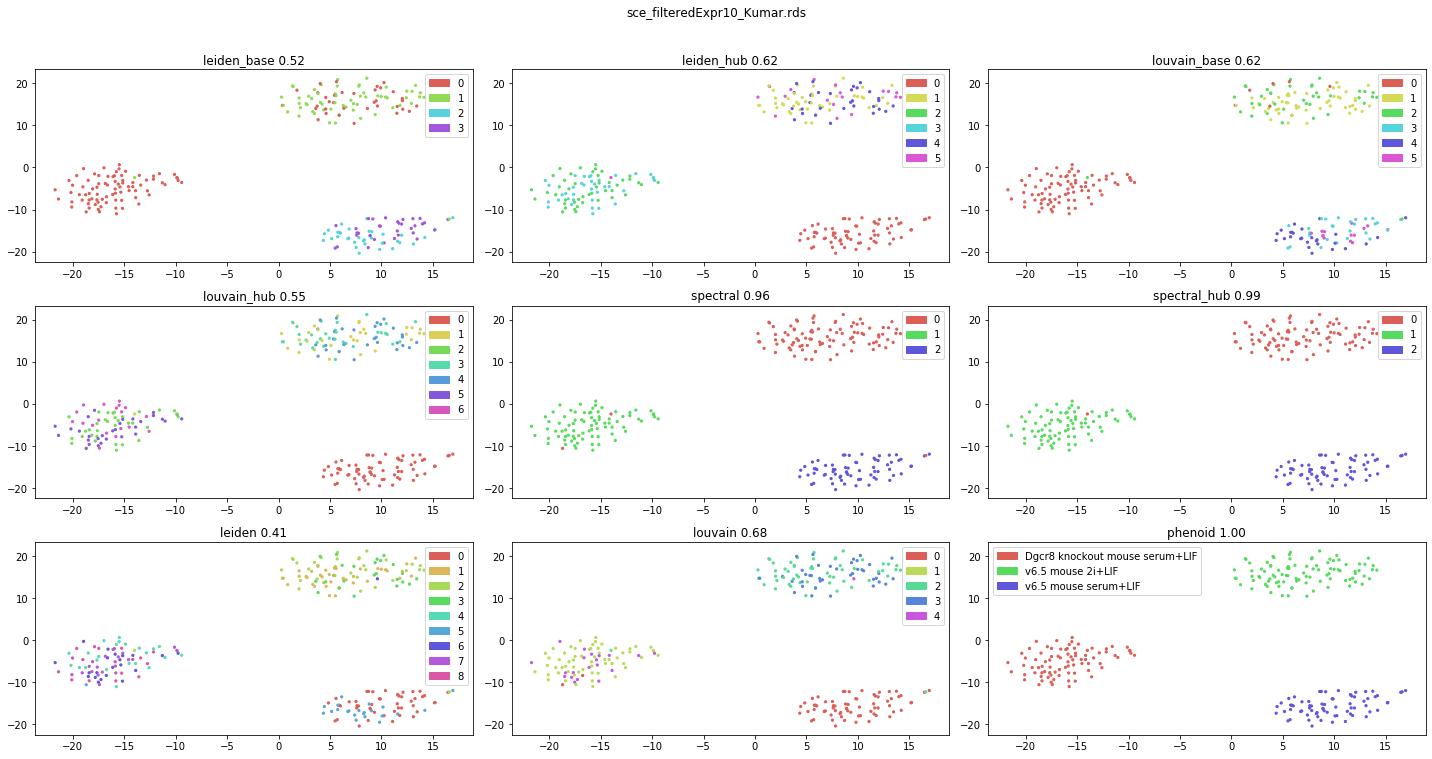

Base hubness  \
k_skewness                                                     0.999386   
k_skewness_truncnorm                                           0.584389   
atkinson                                                         0.1194   
gini                                                           0.360182   
robinhood                                                      0.257724   
antihubs                                         [23, 33, 66, 226, 239]   
antihub_occurrence                                            0.0203252   
hubs                  [1, 17, 22, 26, 35, 39, 41, 43, 57, 63, 64, 82...   
hub_occurrence                                                 0.229675   
groupie_ratio                                                 0.0138211   

                        Reduced hubness  
k_skewness                     0.395883  
k_skewness_truncnorm            0.10042  
atkinson                      0.0374234  
gini                           0.205698  
robinhood                      0.141463  
antihubs                             []  
antihub_occurrence                    0  
hubs                  [22, 26, 41, 199]  
hub_occurrence                0.0341463  
groupie_ratio                0.00934959

... storing 'phenoid' as categorical




-------------------------------------------------------------------------------------------------------------





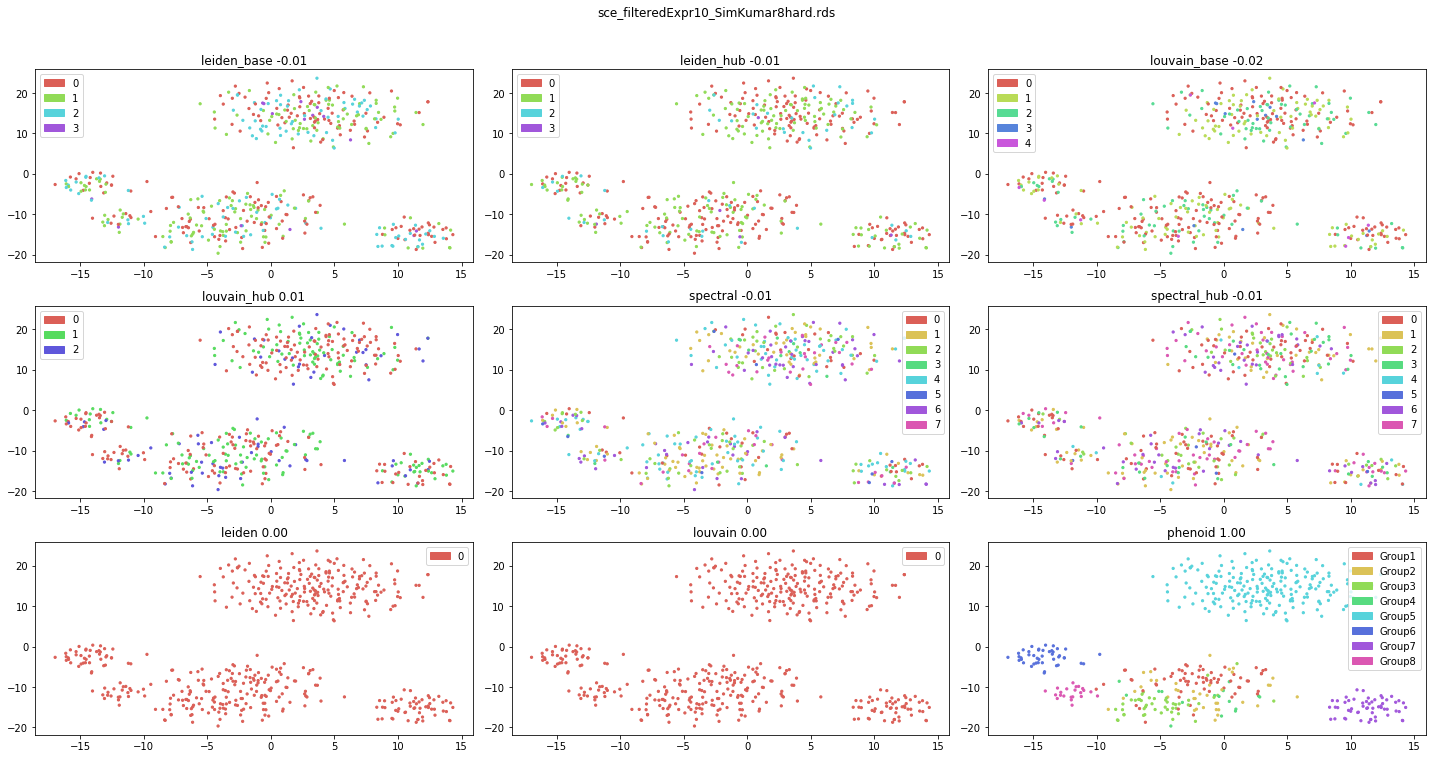

Base hubness  \
k_skewness                                                       6.5056   
k_skewness_truncnorm                                            1.41124   
atkinson                                                       0.969929   
gini                                                           0.976338   
robinhood                                                      0.966132   
antihubs              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
antihub_occurrence                                             0.965932   
hubs                  [327, 328, 329, 330, 331, 332, 333, 334, 335, ...   
hub_occurrence                                                 0.995391   
groupie_ratio                                                 0.0997996   

                                                        Reduced hubness  
k_skewness                                                      6.90659  
k_skewness_truncnorm                                            1.41902  
atkinson                                                       0.971255  
gini                                                           0.978166  
robinhood                                                      0.967134  
antihubs              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
antihub_occurrence                                             0.965932  
hubs                  [252, 253, 254, 255, 256, 257, 258, 259, 260, ...  
hub_occurrence                                                 0.995992  
groupie_ratio                                                 0.0997996

... storing 'Batch' as categorical
... storing 'Group' as categorical
... storing 'phenoid' as categorical
R[write to console]: Loading required package: splatter





-------------------------------------------------------------------------------------------------------------





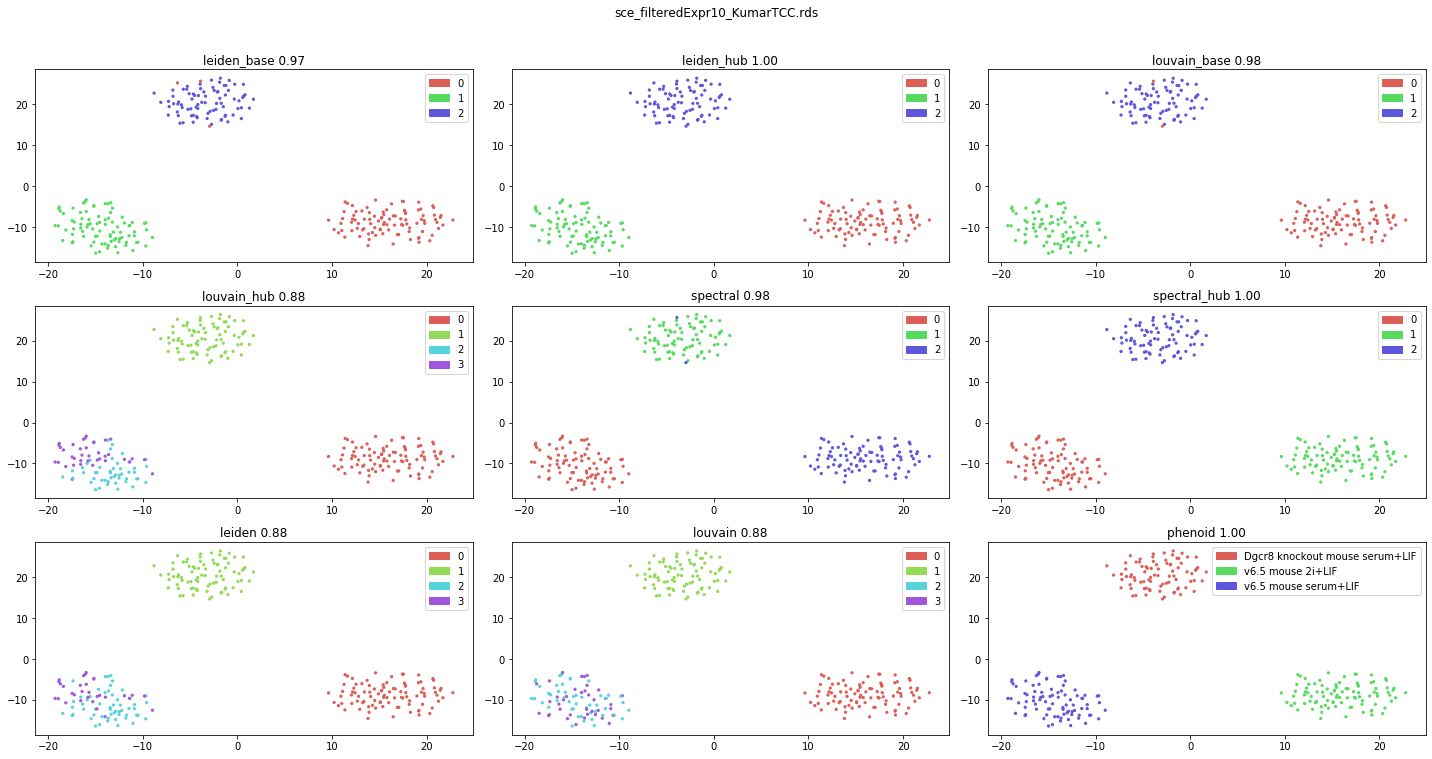

Base hubness  \
k_skewness                                                      2.74686   
k_skewness_truncnorm                                            1.17369   
atkinson                                                       0.692961   
gini                                                           0.829441   
robinhood                                                      0.711027   
antihubs              [1, 5, 6, 7, 10, 11, 13, 14, 16, 17, 20, 24, 2...   
antihub_occurrence                                              0.51711   
hubs                  [8, 9, 18, 44, 50, 51, 52, 54, 55, 57, 65, 67,...   
hub_occurrence                                                 0.851711   
groupie_ratio                                                 0.0505703   

                                                        Reduced hubness  
k_skewness                                                      2.15151  
k_skewness_truncnorm                                            1.00448  
atkinson                                                       0.389773  
gini                                                           0.633023  
robinhood                                                      0.481749  
antihubs              [5, 6, 13, 16, 20, 27, 40, 42, 43, 53, 71, 72,...  
antihub_occurrence                                             0.201521  
hubs                  [2, 8, 9, 39, 44, 50, 51, 52, 54, 57, 65, 67, ...  
hub_occurrence                                                 0.596958  
groupie_ratio                                                 0.0296578

... storing 'phenoid' as categorical




-------------------------------------------------------------------------------------------------------------





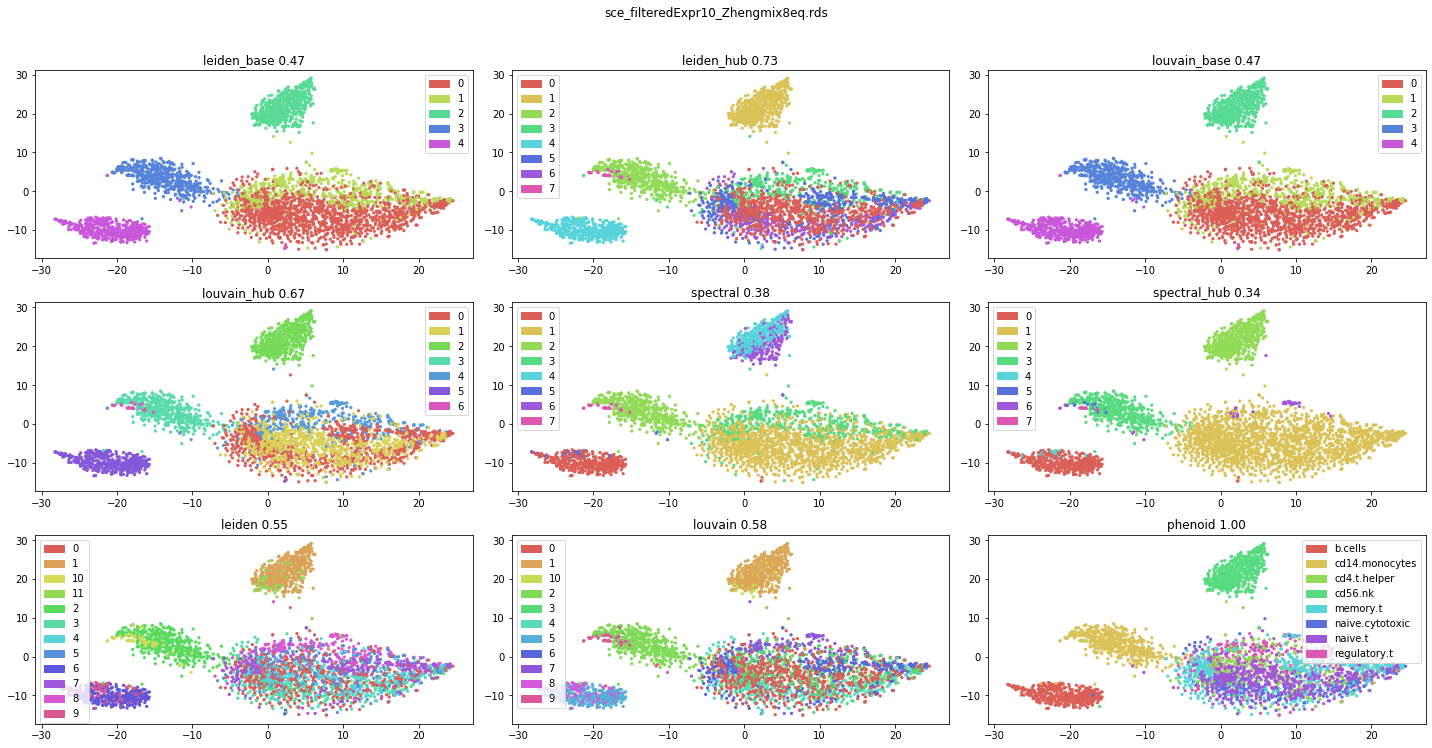

Base hubness  \
k_skewness                                                       8.2762   
k_skewness_truncnorm                                            1.30506   
atkinson                                                       0.751293   
gini                                                           0.880731   
robinhood                                                      0.740619   
antihubs              [0, 3, 4, 5, 6, 7, 10, 11, 13, 14, 18, 19, 20,...   
antihub_occurrence                                             0.532611   
hubs                  [17, 25, 37, 38, 43, 49, 53, 54, 56, 58, 59, 6...   
hub_occurrence                                                 0.833669   
groupie_ratio                                                 0.0170234   

                                                        Reduced hubness  
k_skewness                                                      2.75181  
k_skewness_truncnorm                                           0.988576  
atkinson                                                       0.363648  
gini                                                           0.606575  
robinhood                                                      0.453085  
antihubs              [5, 10, 14, 19, 20, 48, 51, 70, 73, 76, 77, 81...  
antihub_occurrence                                             0.180307  
hubs                  [17, 27, 38, 39, 49, 54, 56, 58, 66, 75, 95, 9...  
hub_occurrence                                                 0.532385  
groupie_ratio                                                0.00357593

... storing 'barcode' as categorical
... storing 'phenoid' as categorical




-------------------------------------------------------------------------------------------------------------





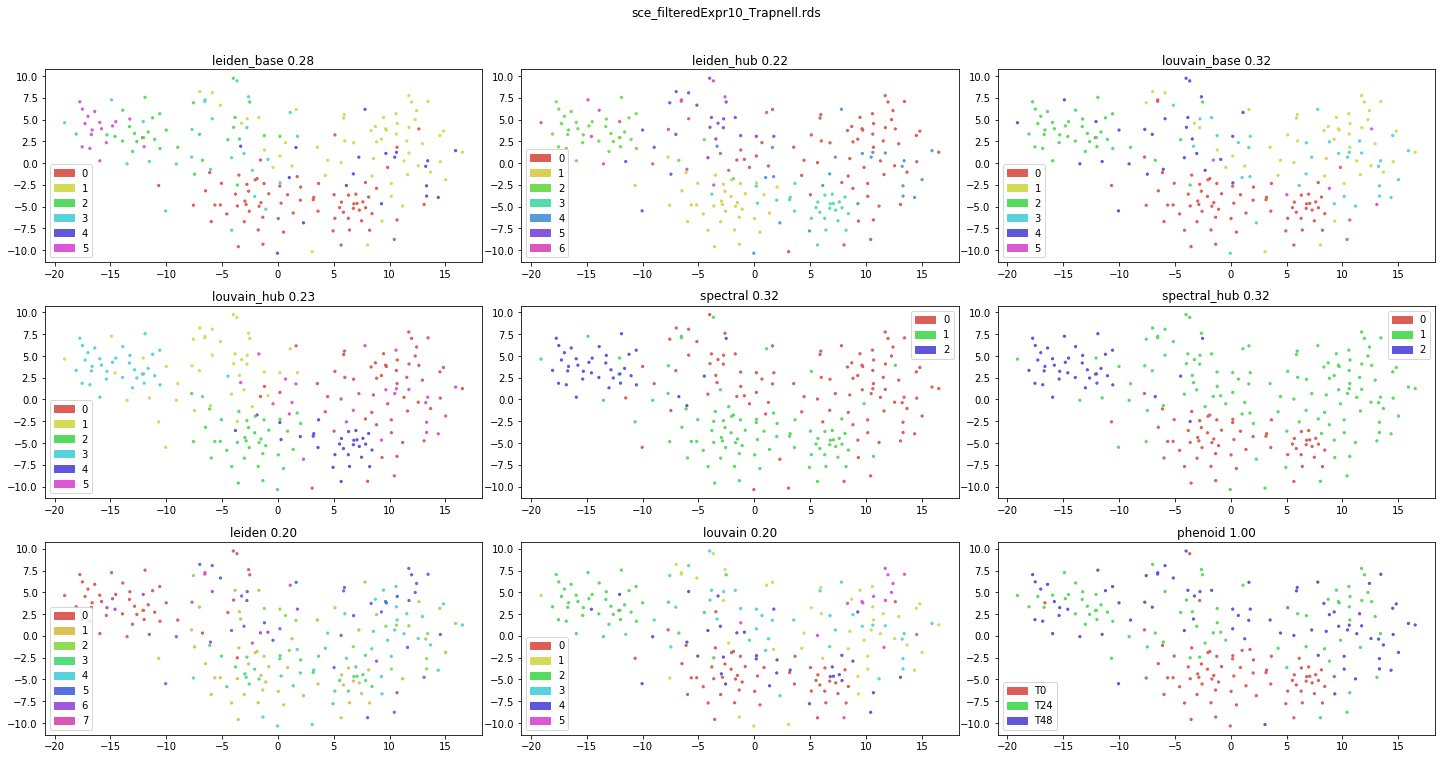

Base hubness  \
k_skewness                                                      1.58948   
k_skewness_truncnorm                                           0.846248   
atkinson                                                        0.23923   
gini                                                           0.497756   
robinhood                                                      0.358108   
antihubs              [5, 22, 24, 31, 42, 76, 88, 90, 91, 114, 116, ...   
antihub_occurrence                                            0.0810811   
hubs                  [14, 19, 27, 29, 32, 37, 44, 49, 53, 57, 61, 6...   
hub_occurrence                                                 0.398198   
groupie_ratio                                                 0.0211712   

                                                        Reduced hubness  
k_skewness                                                     0.562373  
k_skewness_truncnorm                                           0.315518  
atkinson                                                      0.0670149  
gini                                                           0.273046  
robinhood                                                      0.190541  
antihubs                                                          [114]  
antihub_occurrence                                            0.0045045  
hubs                  [29, 32, 37, 57, 67, 74, 83, 149, 154, 188, 19...  
hub_occurrence                                                 0.124775  
groupie_ratio                                                 0.0108108

... storing 'phenoid' as categorical




-------------------------------------------------------------------------------------------------------------





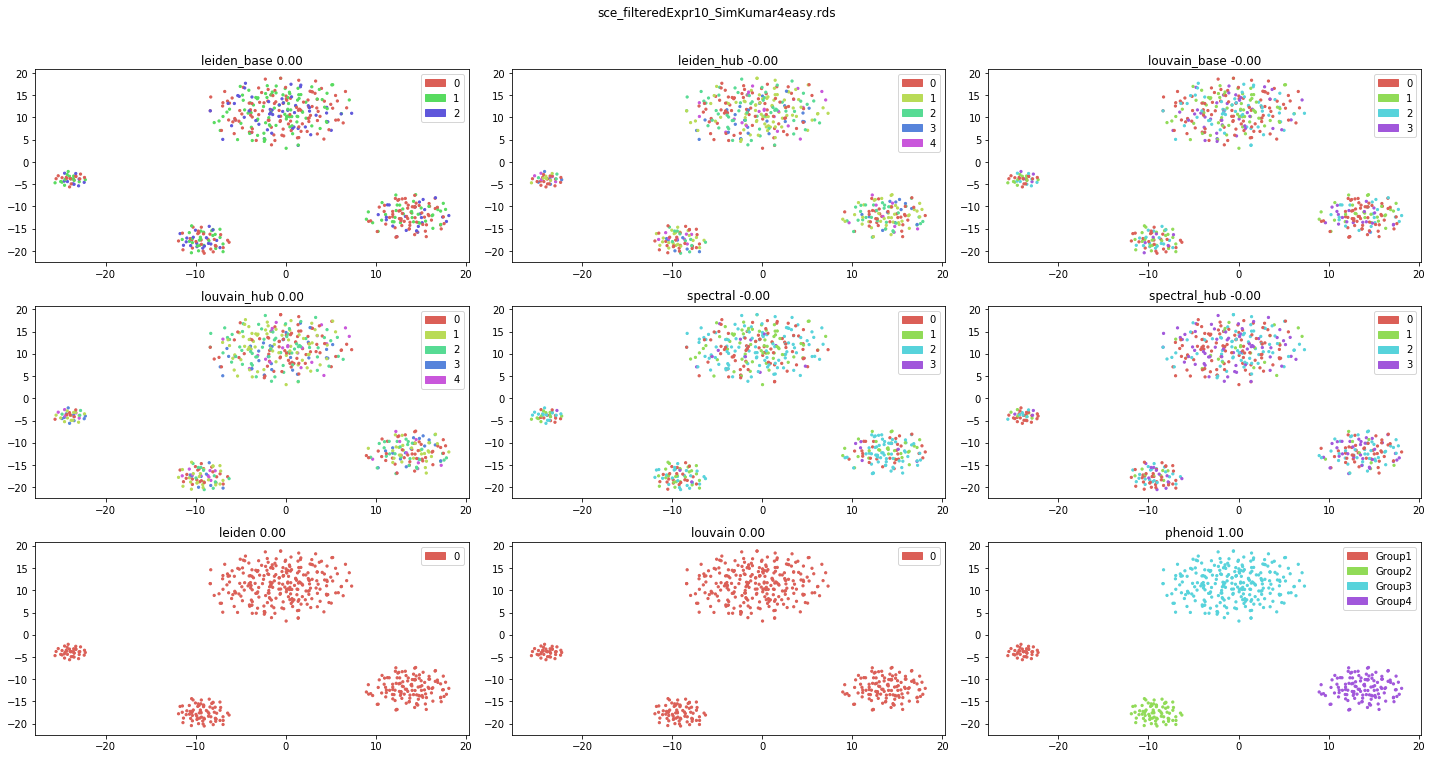

Base hubness  \
k_skewness                                                      6.56732   
k_skewness_truncnorm                                            1.41189   
atkinson                                                       0.970084   
gini                                                           0.976476   
robinhood                                                        0.9672   
antihubs              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
antihub_occurrence                                                0.966   
hubs                  [328, 329, 330, 331, 332, 333, 334, 335, 336, ...   
hub_occurrence                                                   0.9956   
groupie_ratio                                                    0.0998   

                                                        Reduced hubness  
k_skewness                                                      6.87294  
k_skewness_truncnorm                                            1.42315  
atkinson                                                       0.973429  
gini                                                           0.979025  
robinhood                                                        0.9696  
antihubs              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
antihub_occurrence                                                0.968  
hubs                  [253, 254, 255, 256, 257, 258, 259, 260, 261, ...  
hub_occurrence                                                   0.9964  
groupie_ratio                                                    0.0998

... storing 'Batch' as categorical
... storing 'Group' as categorical
... storing 'phenoid' as categorical




-------------------------------------------------------------------------------------------------------------





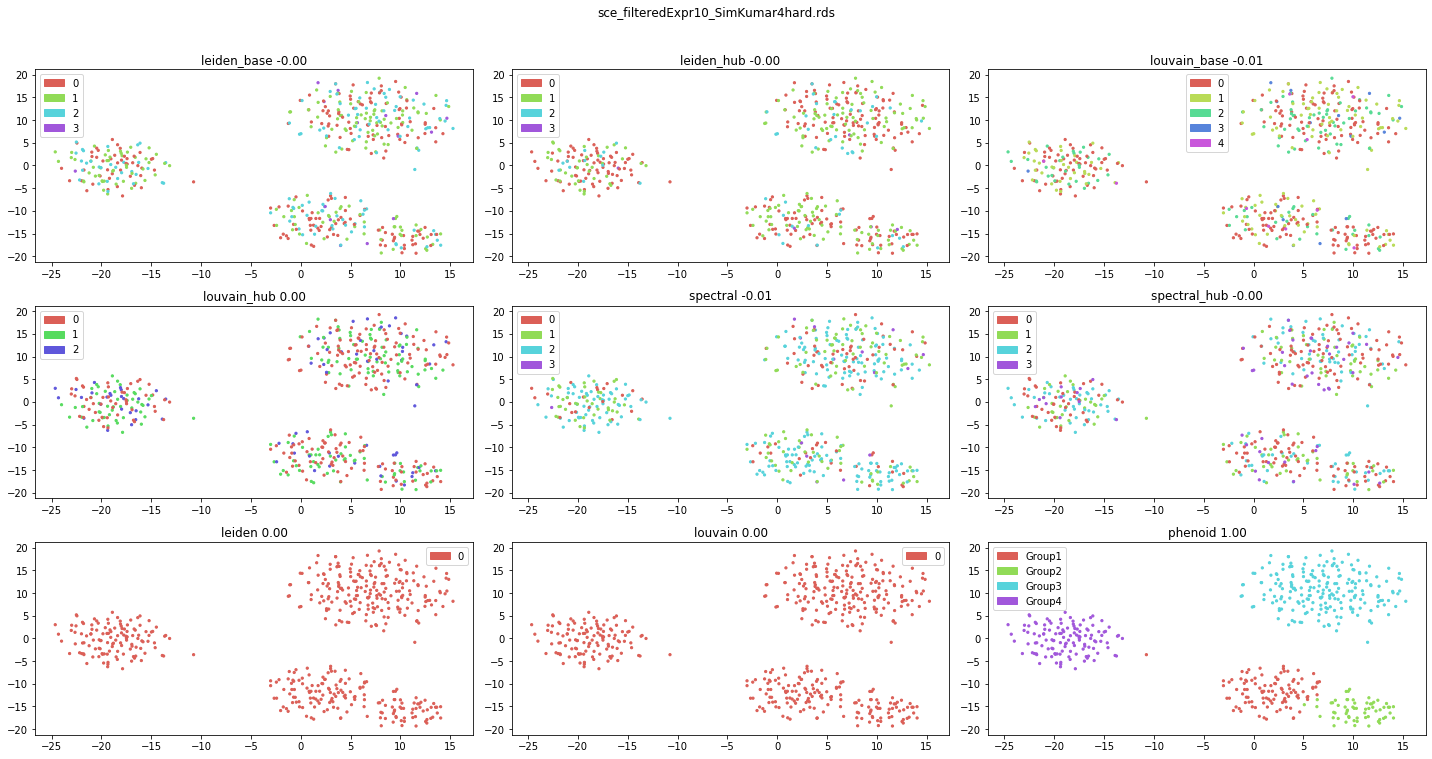

Base hubness  \
k_skewness                                                       6.5056   
k_skewness_truncnorm                                            1.41124   
atkinson                                                       0.969929   
gini                                                           0.976338   
robinhood                                                      0.966132   
antihubs              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
antihub_occurrence                                             0.965932   
hubs                  [327, 328, 329, 330, 331, 332, 333, 334, 335, ...   
hub_occurrence                                                 0.995391   
groupie_ratio                                                 0.0997996   

                                                        Reduced hubness  
k_skewness                                                      6.90659  
k_skewness_truncnorm                                            1.41902  
atkinson                                                       0.971255  
gini                                                           0.978166  
robinhood                                                      0.967134  
antihubs              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
antihub_occurrence                                             0.965932  
hubs                  [252, 253, 254, 255, 256, 257, 258, 259, 260, ...  
hub_occurrence                                                 0.995992  
groupie_ratio                                                 0.0997996

... storing 'Batch' as categorical
... storing 'Group' as categorical
... storing 'phenoid' as categorical




-------------------------------------------------------------------------------------------------------------





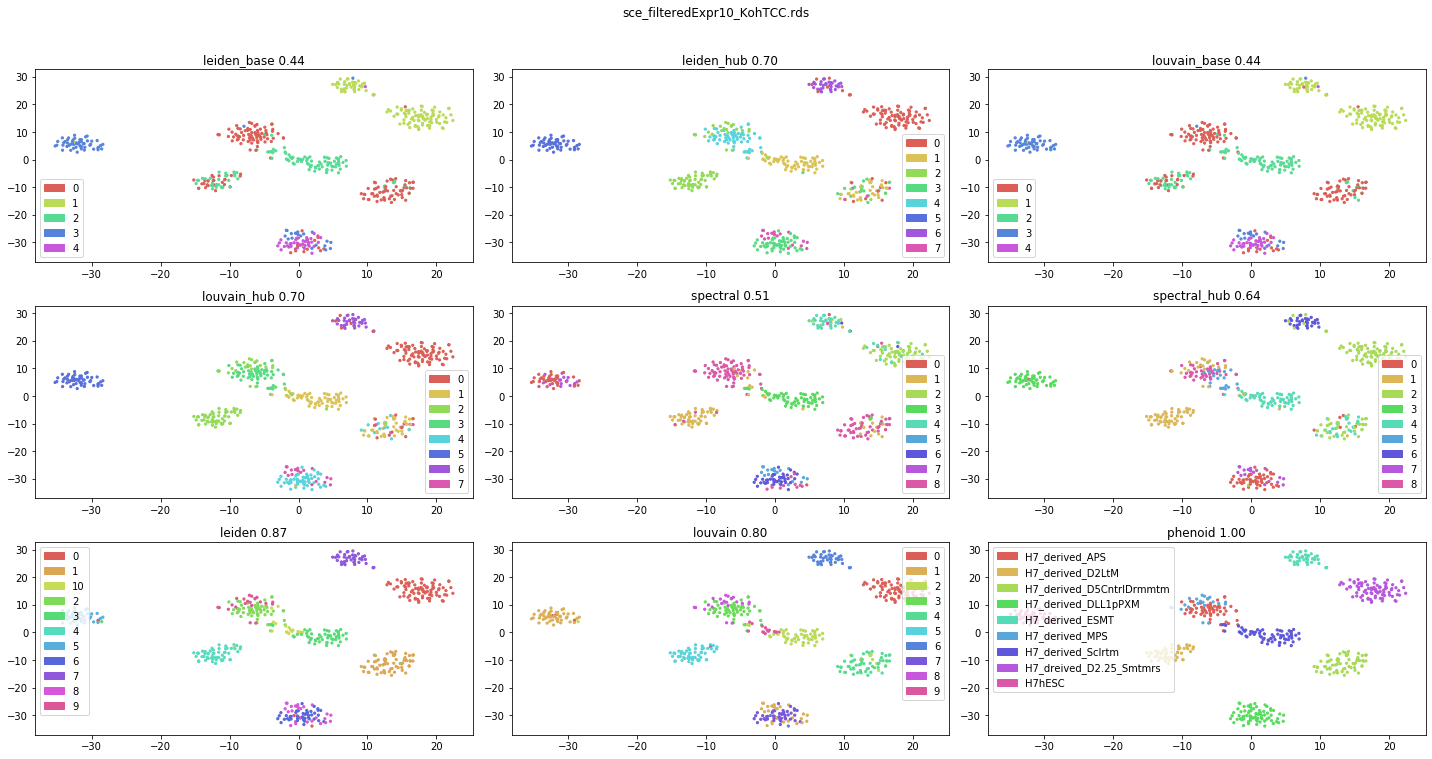

In [ ]:
rootdir = '/home/utilisateur/Downloads/DuoClustering2018/sce_filteredExpr10/'

fnames = os.listdir(rootdir)
fnames = [f for f in fnames if 'sce' in f and '.h5ad' not in f]
for fname in fnames:
    
    adata = readRDS(rootdir+fname)
    clustering_analysis(adata,plot_title=fname)
    
    adata.write(rootdir+fname[:-4]+'.h5ad')
    %xdel adata
    gc.collect()
    
    print("\n\n-------------------------------------------------------------------------------------------------------------\n\n\n")

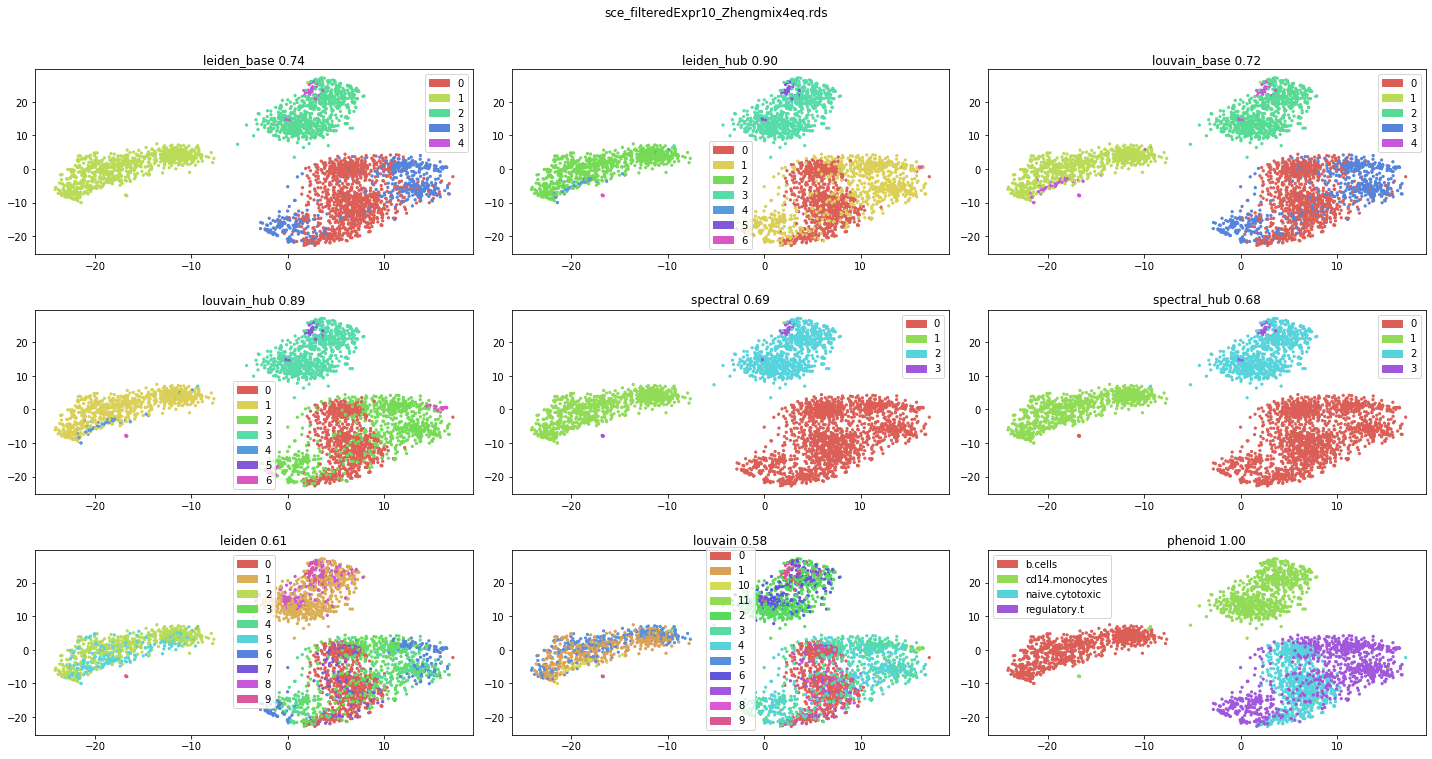

Base hubness  \
k_skewness                                                      7.05231   
k_skewness_truncnorm                                            1.27305   
atkinson                                                       0.724546   
gini                                                           0.863104   
robinhood                                                      0.720253   
antihubs              [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 1...   
antihub_occurrence                                              0.51308   
hubs                  [14, 20, 30, 31, 36, 42, 45, 46, 48, 69, 86, 8...   
hub_occurrence                                                  0.81699   
groupie_ratio                                                 0.0148523   

                                                        Reduced hubness  
k_skewness                                                      2.64055  
k_skewness_truncnorm                                           0.990211  
atkinson                                                       0.367075  
gini                                                           0.610323  
robinhood                                                      0.457075  
antihubs              [4, 5, 9, 15, 16, 17, 19, 33, 38, 41, 44, 63, ...  
antihub_occurrence                                             0.181997  
hubs                  [0, 13, 14, 20, 21, 22, 30, 31, 32, 36, 42, 46...  
hub_occurrence                                                 0.545992  
groupie_ratio                                                0.00351617

... storing 'barcode' as categorical
... storing 'phenoid' as categorical




-------------------------------------------------------------------------------------------------------------





In [6]:
rootdir = '/home/utilisateur/Downloads/DuoClustering2018/sce_filteredExpr10/'

fnames = os.listdir(rootdir)
fnames = [f for f in fnames if 'sce' in f and '.h5ad' not in f]
for fname in fnames[-1:]:
    
    adata = readRDS(rootdir+fname)
    clustering_analysis(adata,plot_title=fname)
    
    adata.write(rootdir+fname[:-4]+'.h5ad')
    %xdel adata
    gc.collect()
    
    print("\n\n-------------------------------------------------------------------------------------------------------------\n\n\n")

# Run all datasets full

In [3]:
rootdir = '/home/utilisateur/Downloads/DuoClustering2018/sce_full/'

fnames = os.listdir(rootdir)
fnames = [f for f in fnames if 'sce' in f and '.h5ad' not in f]
for fname in fnames:
    
    adata = readRDS(rootdir+fname)
    clustering_analysis(adata,weighted=False,plot_title=fname)
    
    adata.write(rootdir+fname[:-4]+'.h5ad')
    %xdel adata
    gc.collect()
    
    print("\n\n-------------------------------------------------------------------------------------------------------------\n\n\n")

KeyError: 'Attribute does not exist'